In [1]:
!nvidia-smi
!pip install -q tensorflow-gpu==2.0.0-alpha0

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

     |████████████████████████████████| 332.1MB 62kB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 419kB 45.6MB/s 
     |████████████████████████████████| 3.0MB 41.5MB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
from os import listdir
from os.path import isfile, join
import os.path
import random 
import cv2
from sklearn.preprocessing import normalize
import zipfile
import tensorflow as tf
from tensorflow.keras.models import load_model

In [3]:
!apt-get install openslide-tools
!pip install openslide-python

from openslide import open_slide, __library_version__ as openslide_version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (96.3 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

### MOUNT DRIVE AND LOAD TEST SLIDE

In [4]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Colab Notebooks/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!pwd

/content/gdrive/My Drive/Colab Notebooks


In [35]:
# Download an example slide and tumor mask
slide_path = os.path.join(os.getcwd(), 'slides/tumor_091.tif')
tumor_mask_path = os.path.join(os.getcwd(), 'slides/tumor_091_mask.tif')
print(slide_path)
print(tumor_mask_path)

# slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
# mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# # Download the whole slide image
# if not os.path.exists(slide_path):
#   !curl -O $slide_url

# # Download the tumor mask
# if not os.path.exists(tumor_mask_path):
#   !curl -O $mask_url

/content/gdrive/My Drive/Colab Notebooks/slides/tumor_091.tif
/content/gdrive/My Drive/Colab Notebooks/slides/tumor_091_mask.tif


In [0]:
def read_slide(slide, x, y, level, width=-1, height=-1, as_float=False):
    width = slide.level_dimensions[level][0] if width < 0 else width
    height = slide.level_dimensions[level][1] if height < 0 else height
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

### **LOAD SAVED MODELS FOR GENERATING HEATMAPS AND CONFUSION MATRIX**

In [11]:
!pwd
!ls

/content/gdrive/My Drive/Colab Notebooks
4.3-transfer-learning.ipynb	    models.ipynb
basic_classification.ipynb	    slides
confusionMatrix.ipynb		    tumor_091_mask.tif
data				    tumor_091.tif
data_extract.ipynb		    z2_custom_15_epoch.h5
first_steps_with_tensor_flow.ipynb  z2_inception_20_epoch.h5
Heatmap_negi.ipynb		    z2_inception_20_epoch_history.txt
heat_maps.ipynb			    z3_custom_15_epoch.h5


In [0]:
# load all compiled models from gdrive
# model_z2 = load_model('z2_inception_20_epoch.h5')
# my_model_z2 = load_model('z2_custom_15_epoch.h5')
my_model_z3 = load_model('z3_custom_15_epoch.h5')

## CONFUSION MATRIX PLOTS

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import *

TARGET_SHAPE = 299 
BATCH_SIZE = 32

def get_image_gen(level):
    train_dir = 'data/train/z{}'.format(level)
    val_dir = 'data/val/z{}'.format(level)
    print('Train dir: ', train_dir)
    print('Val dir: ', val_dir)

    image_gen_train = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         vertical_flip=True)
#                                          rotation_range=90)
    image_gen_val = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_gen_train.flow_from_directory(
        batch_size=BATCH_SIZE,
        directory=train_dir,
        shuffle=True,
        target_size=(TARGET_SHAPE,TARGET_SHAPE),
        class_mode='binary')

    # Validation data should not be augmented!
    val_data_gen = image_gen_val.flow_from_directory(
        batch_size=BATCH_SIZE, 
        directory=val_dir, 
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        class_mode='binary')

    return train_data_gen, val_data_gen

Using TensorFlow backend.


In [0]:
# this code was taken from 
# https://scikit-learn.org/stable/auto_examples/model_selection/
# plot_confusion_matrix.html#
# sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Confusion Matrix for Transfer Learning Model (Inception) for Zoom Level 2

In [30]:
train_data_gen_z2, val_data_gen_z2 = get_image_gen(2)
y_pred_model_z2 = model_z2.predict_classes(val_data_gen_z2)

Train dir:  data/train/z2
Val dir:  data/val/z2
Found 953 images belonging to 2 classes.
Found 1238 images belonging to 2 classes.


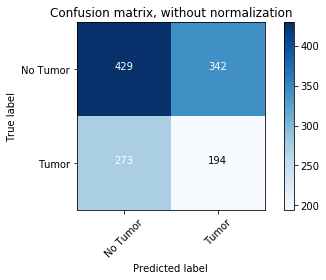

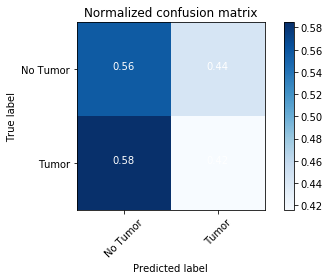

In [31]:
# y_pred = model_z2.predict_classes(val_data_gen_z2)
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z2.classes, y_pred_model_z2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Confusion Matrix for Custom Model for Zoom Level 2

In [28]:
train_data_gen_z2, val_data_gen_z2 = get_image_gen(2)
y_pred_my_model_z2 = my_model_z2.predict_classes(val_data_gen_z2)

Train dir:  data/train/z2
Val dir:  data/val/z2
Found 953 images belonging to 2 classes.
Found 1238 images belonging to 2 classes.


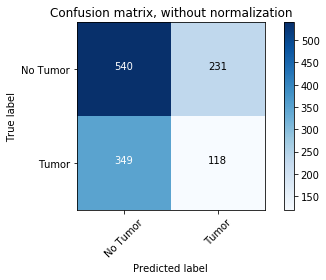

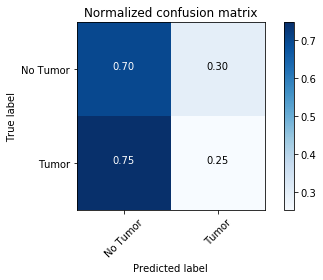

In [29]:
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z2.classes, y_pred_my_model_z2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Confusion Matrix for Custom Model for Zoom Level 3

In [0]:
train_data_gen_z3, val_data_gen_z3 = get_image_gen(3)
y_pred_my_model_z3 = my_model_z3.predict_classes(val_data_gen_z3)

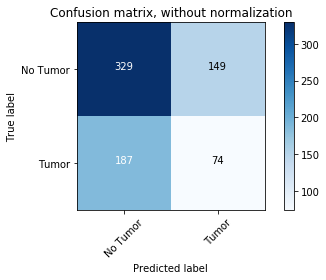

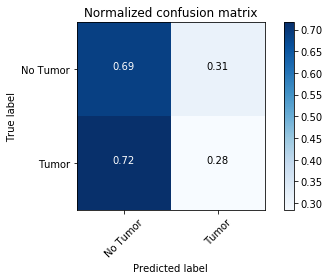

In [33]:
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z3.classes, y_pred_my_model_z3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## HEATMAP PLOTS

In [0]:
image_dim = 299

def rgb(value, minimum=0.0, maximum=1.0):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return np.asarray([r, g, b])
  
def resize_image(image, width, height):
    # returns a resized numpy array
    tensor = tf.convert_to_tensor(image)
    image_resized_tensor = tf.cast(tf.image.resize(tensor, (width, height)),  tf.uint8)
    return image_resized_tensor.numpy()

def heat_map_grid(im, learningModel, width, height, color_range=False):
    # returns a mask of dimensions (width, height)
    # if color_range is True, then the squares will be colored based on probabilities
    # otherwise if False, the squares are red only if classified as "tumor"
    x = im.shape[0]
    y = im.shape[1]
    x_divisor = x/width
    y_divisor = y/height
    num_tumor = 0
    heat_mask = np.zeros((width, height), dtype = int) if not color_range else np.zeros((width, height, 3))
    im_slice = np.zeros((image_dim, image_dim, 3))
    xrange = int(np.ceil(x / image_dim))
    yrange = int(np.ceil(y / image_dim))
    
    
    for i in range(xrange):
        print("Generating heatmap for row {}.".format(i))
        lower_x = i * image_dim
        upper_x = min(x, (i+1) * image_dim)
        for j in range(yrange):
            lower_y = j * image_dim
            upper_y = min(y, (j+1) * image_dim)

            im_slice[:,:,:] = 0
            im_slice[:(upper_x - lower_x), :(upper_y - lower_y)] = im[lower_x: upper_x, lower_y: upper_y]
            prediction = learningModel.predict_classes(np.asarray([im_slice]))[0][0] if not color_range else learningModel.predict(np.asarray([im_slice]))[0][0]
      
            if color_range:
                heat_mask[int(lower_x/x_divisor): int(upper_x/x_divisor), 
                          int(lower_y/y_divisor): int(upper_y/y_divisor)] = rgb(prediction)
            else:
                if prediction > 0: # if tumor is detected by the model
                    # make heat mask 1's
                    num_tumor += 1
                    heat_mask[int(lower_x/x_divisor): int(upper_x/x_divisor), 
                              int(lower_y/y_divisor): int(upper_y/y_divisor)] = 255
          
    print("number of windows with tumor: %d" %(num_tumor))
    return heat_mask

In [0]:
def heat_map(im, learningModel, width, height, stride):
    # returns a mask of dimensions (width, height)
    # if color_range is True, then the squares will be colored based on probabilities
    # otherwise if False, the squares are red only if classified as "tumor"
    x = im.shape[0]
    y = im.shape[1]
    x_divisor = x/width
    y_divisor = y/height
    num_tumor = 0
    
    heat_mask = np.zeros((width, height)) 
    
    im_slice = np.zeros((image_dim, image_dim, 3))
    
    for i in range(0, x - image_dim, stride):
#         print("Generating heatmap for pixel {}.".format(i))
        lower_x = i
        upper_x = i + image_dim
   
        for j in range(0, y - image_dim, stride):
          lower_y = j
          upper_y = j + image_dim

          im_slice[:,:,:] = 0
          im_slice[:(upper_x - lower_x), :(upper_y - lower_y)] = im[lower_x: upper_x, lower_y: upper_y]
          prediction = learningModel.predict(np.asarray([im[lower_x: upper_x, lower_y: upper_y]]))[0][0]

          num_tumor += 1
          heat_mask[int(lower_x/x_divisor): int(upper_x/x_divisor), 
                    int(lower_y/y_divisor): int(upper_y/y_divisor)] += prediction

    print("number of windows with tumor: %d" %(num_tumor))
    return heat_mask

## Heatmap for Custom Model for Zoom Level 2 On Test Slide

In [0]:
slide = open_slide(slide_path)

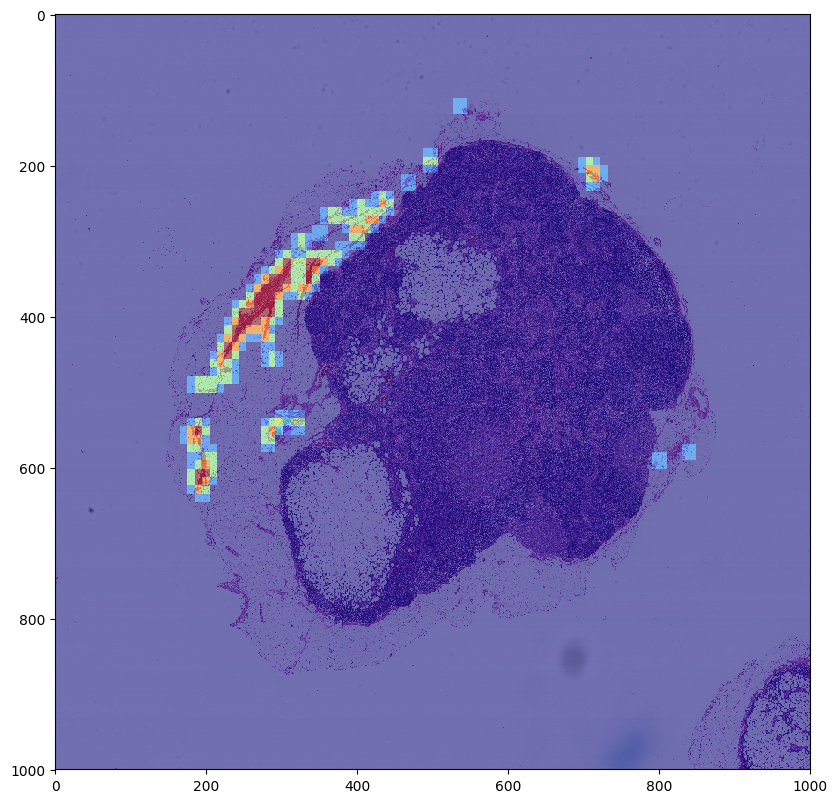

In [0]:
slide_image_z2 = read_slide(slide, x=0, y=0, level=2)
width, height = 1000, 1000

heat_mask = heat_map(slide_image_z2, my_model_z2, width, height, 150)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resize_image(slide_image_z2, width, height))
plt.imshow(heat_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

Generating heatmap for pixel 0.
Generating heatmap for pixel 150.
Generating heatmap for pixel 300.
Generating heatmap for pixel 450.
Generating heatmap for pixel 600.
Generating heatmap for pixel 750.
Generating heatmap for pixel 900.
Generating heatmap for pixel 1050.
Generating heatmap for pixel 1200.
Generating heatmap for pixel 1350.
Generating heatmap for pixel 1500.
Generating heatmap for pixel 1650.
Generating heatmap for pixel 1800.
Generating heatmap for pixel 1950.
Generating heatmap for pixel 2100.
Generating heatmap for pixel 2250.
Generating heatmap for pixel 2400.
Generating heatmap for pixel 2550.
Generating heatmap for pixel 2700.
Generating heatmap for pixel 2850.
Generating heatmap for pixel 3000.
Generating heatmap for pixel 3150.
Generating heatmap for pixel 3300.
Generating heatmap for pixel 3450.
Generating heatmap for pixel 3600.
Generating heatmap for pixel 3750.
Generating heatmap for pixel 3900.
Generating heatmap for pixel 4050.
Generating heatmap for pixel 

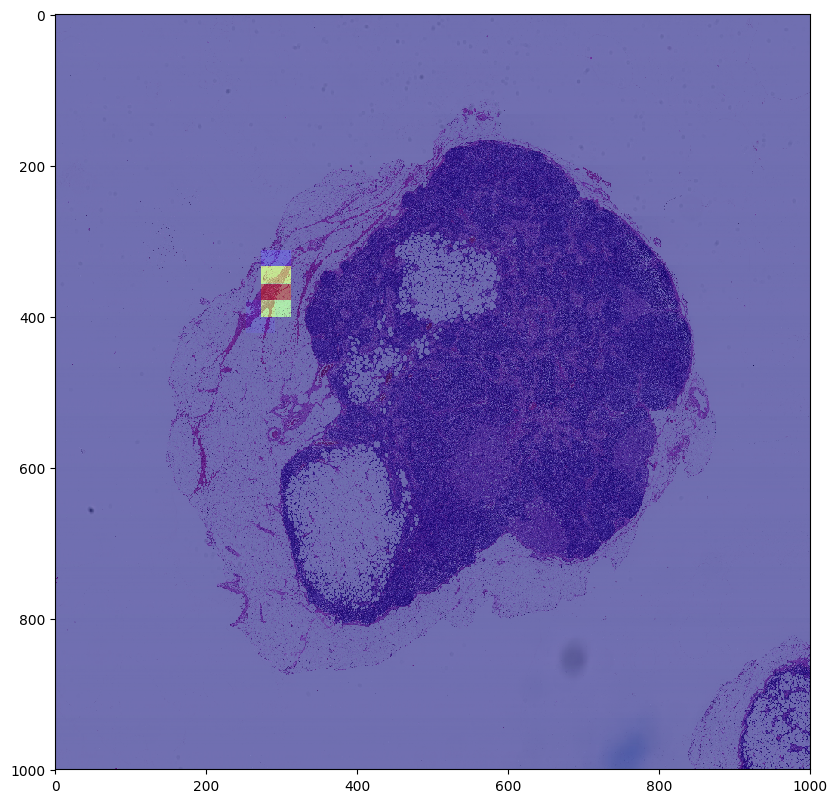

In [40]:
slide_image_z3 = read_slide(slide, x=0, y=0, level=3)
width, height = 1000, 1000

heat_mask = heat_map(slide_image_z3, my_model_z3, width, height, 150)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resize_image(slide_image_z3, width, height))
plt.imshow(heat_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

Generating heatmap for pixel 0.
Generating heatmap for pixel 150.
Generating heatmap for pixel 300.
Generating heatmap for pixel 450.
Generating heatmap for pixel 600.
Generating heatmap for pixel 750.
Generating heatmap for pixel 900.
Generating heatmap for pixel 1050.
Generating heatmap for pixel 1200.
Generating heatmap for pixel 1350.
Generating heatmap for pixel 1500.
Generating heatmap for pixel 1650.
Generating heatmap for pixel 1800.
Generating heatmap for pixel 1950.
Generating heatmap for pixel 2100.
Generating heatmap for pixel 2250.
Generating heatmap for pixel 2400.
Generating heatmap for pixel 2550.
Generating heatmap for pixel 2700.
Generating heatmap for pixel 2850.
Generating heatmap for pixel 3000.
Generating heatmap for pixel 3150.
Generating heatmap for pixel 3300.
Generating heatmap for pixel 3450.
Generating heatmap for pixel 3600.
Generating heatmap for pixel 3750.
Generating heatmap for pixel 3900.
Generating heatmap for pixel 4050.
Generating heatmap for pixel 

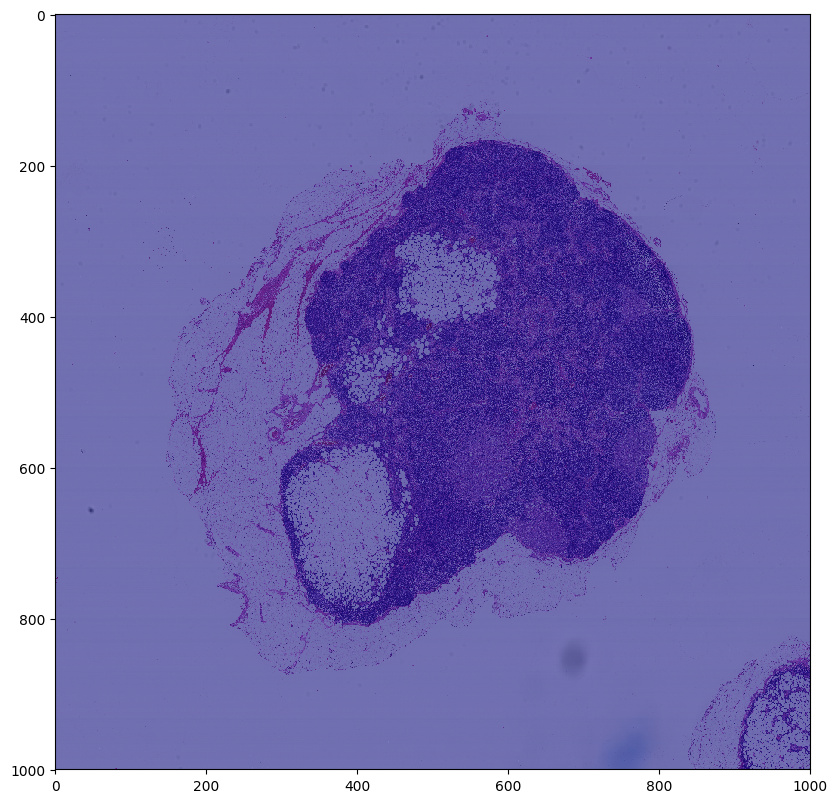

In [41]:
slide_image_z2 = read_slide(slide, x=0, y=0, level=2)
width, height = 1000, 1000

heat_mask = heat_map(slide_image_z2, model_z2, width, height, 150)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resize_image(slide_image_z2, width, height))
plt.imshow(heat_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.